# Дисклеймер
Эту тетрадку лучше запускать в колабе. 

In [3]:
# %pip install --upgrade keras
# %pip install torch torchvision torchaudio

In [6]:
# %pip install scikit-learn pandas matplotlib

## Сверточные нейронные сети

Несколько полносвязных слоев (с нелинейностями посередине) - это уже полноценная нейронная сеть. Однако cам по себе полносвязный слой обычно встречается только в конце сети, когда нужно получить распределение по классам или итоговое значение (в регрессии). Дальше мы разберем три более сложных типа слоев: сверточные, реккуретные и трасформерные. Все они так или иначе нацелены на учитывание структуры данных. 

В этом семинаре мы попробуем использовать сверточные слои. Лучше всего они работают в картинках (мы тоже это попробуем в конце семинара), но для текстов их тоже можно применять (они быстрее рекуррентных и могут лучше работать на длинных последовательностях). И в целом они подходят для любых последовательных данных. К последовательности тоже можно применять полносвязный слой, но либо к каждому элементу по отдельности либо нужно соединить отдельные элементы в один входной вектор и применить полносвязный слой сразу ко всему. Оба этих варианта работают так себе, так как в первом не учитывается последовательность (опять получается мешок слов), а во втором мешает то, что последовательности бывают разной длины и отдельные части могут менять свои позиции. В сверточных сетях используется промежуточное решение - объеденяются только несколько стоящих к друг друг векторов и используется скользящее окно, чтобы применить полносвязный слой к отдельным группам векторов. Это по сути объединение токенов в нграммы! Таким образом в сверточных сетях учитывается локальная информация о последовательности. Давайте посмотрим на картинках:

Обычный полносвязный слой:  
[![Screenshot-2025-01-23-at-12-21-16.png](https://i.postimg.cc/ryZ2Lt8K/Screenshot-2025-01-23-at-12-21-16.png)](https://postimg.cc/Z0NM8nvS)

Применение полносвязного слоя к каждому элементу по отдельности:  
[![Screenshot-2025-01-23-at-12-21-42.png](https://i.postimg.cc/jSg7HcKR/Screenshot-2025-01-23-at-12-21-42.png)](https://postimg.cc/RWth9cNY)

Конкатенация всех векторов в один и применение полносвязнного слоя:  
[![Screenshot-2025-01-23-at-12-21-51.png](https://i.postimg.cc/D09CwhjY/Screenshot-2025-01-23-at-12-21-51.png)](https://postimg.cc/H8t06qCQ)

Группировка векторов и применение векторов к отдельным группам скользящим окном (сверточная сеть):  
[![Screenshot-2025-01-23-at-12-22-02.png](https://i.postimg.cc/wvs483Fs/Screenshot-2025-01-23-at-12-22-02.png)](https://postimg.cc/ZB4x6bGT)


Можно еще посмотреть на каждую строчку в матрице весов полносвязного слоя по отдельности и тогда получится, что к каждой группе векторов применяется один вектор, а в результате получается одно число. Между двумя векторами считается скалярное произведение и поэтому можно думать про это как расчет близости! По сути в сверточной сети происходит поиск паттернов в данных. Только эти паттерны модель создает сама в процессе обучения и затем ищет похожие во входных данных. 


Идея гораздно нагляднее в примере с картинкой. В этом случае модель как бы пробегает по картинке взглядом, при это на каждом шаге фокус очень небольшой и модель не видит то, что вокруг. Каждый маленький полновсвязный ищет взглядом на картинке/тексте что-то свое и, если он это находит, то он активируется. В итоге получается абстрактное описание того, что изображено на картинке.

![](https://miro.medium.com/v2/resize:fit:1052/0*jLoqqFsO-52KHTn9.gif)

Более детальный разбор светочных сетей можете посмотреть вот тут - https://www.youtube.com/watch?v=bNb2fEVKeEo


## Классификация с помощью CNN

Давайте посмотрим, как в керасе использовать сверточные сети и как их соединять с Embedding и Dense слоями.

In [1]:
# в новой версии кераса можно использовать разные бекэнды, можно попробовать торч
# если заменить на tensorflow или jax то код также будет работать
# но нужно заранее установить нужный фреймворк
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
print(keras.__version__)

3.8.0


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Возьмем задачу классификации длинных текстов

In [11]:
data = pd.read_csv('lenta_40k.csv.zip')

In [12]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


Предобработка нам тут особо не важна.

In [13]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [14]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [15]:
len(vocab)

354611

In [16]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [17]:
len(filtered_vocab)

24091

In [18]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [19]:
id2word = {i:word for word, i in word2id.items()}

In [20]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [21]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [22]:
MEAN_LEN = np.median([len(x) for x in X])

In [26]:
MAX_LEN, int(MEAN_LEN)

(200, 170)

In [27]:
MAX_LEN = int(MEAN_LEN + 30)

In [28]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [29]:
X.shape

(44356, 200)

In [30]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [31]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [32]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Для сравнения сначала обучим сеть только с помощью Dense слоев.

In [35]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
concat = keras.layers.Flatten()(embeddings)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              # фмеры тут нет, но есть точность и полнота по отдельности, 
              # name тут нужен для удобства,
              # иначе метрика будет называться типа "Precision_i"
              # и придется менять i в дальнейших визуализациях 
              metrics=[keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall')])



In [36]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 30)        │       722,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │       114,019 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 836,779 (3.19 MB)

 Trainable params: 836,779 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7476 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3243 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2798 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1201 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0316 - precision: 0.3062 - recall: 1.9178e-04 - val_loss: 1.8006 - val_precision: 0.9630 - val_recall: 0.0117
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6736 - precision: 0.9324 - recall: 0.0502 - val_loss: 1.5032 - val_precision: 0.8883 - val_recall: 0.1506
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3612 - precision: 0.9128 - recall: 0.2220 - val_loss: 1.2945 - val_precision: 0.8630 - val_recall: 0.3237
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1287 - precision: 0.8966 - recall: 0.4158 - val_loss: 1.1294 - val_precis

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


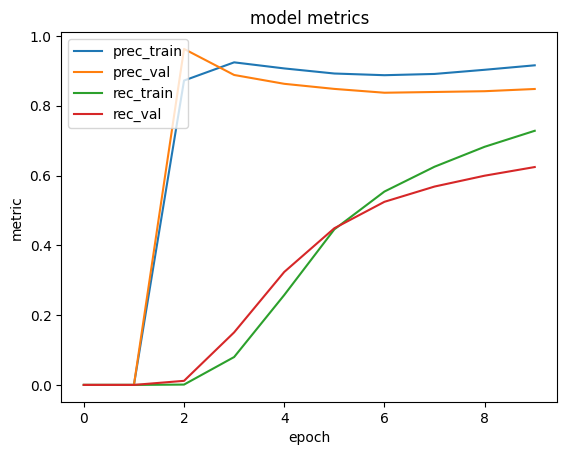

In [38]:
print(model.history.history.keys())
plt.plot(model.history.history['precision'])
plt.plot(model.history.history['val_precision'])
plt.plot(model.history.history['recall'])
plt.plot(model.history.history['val_recall'])
plt.title('model metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['prec_train', 'prec_val', 'rec_train', 'rec_val'], loc='upper left')
plt.show()

In [39]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
transformed_embeddings = keras.layers.Dense(30)(embeddings)
concat = keras.layers.Flatten()(transformed_embeddings)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall')])

In [40]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 200, 30)        │       722,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200, 30)        │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 19)             │       114,019 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 837,709 (3.20 MB)

 Trainable params: 837,709 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6946 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2894 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2256 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0203 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8787 - precision: 0.8299 - recall: 0.0169 - val_loss: 1.5866 - val_precision: 0.9008 - val_recall: 0.0983
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4431 - precision: 0.8936 - recall: 0.1693 - val_loss: 1.2944 - val_precision: 0.8601 - val_recall: 0.3048
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1170 - precision: 0.8901 - recall: 0.4223 - val_loss: 1.0756 - val_precision: 0.8358 - val_recall: 0.5005
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8599 - precision: 0.8817 - recall: 0.5830 - val_loss: 0.9538 - val_preci

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


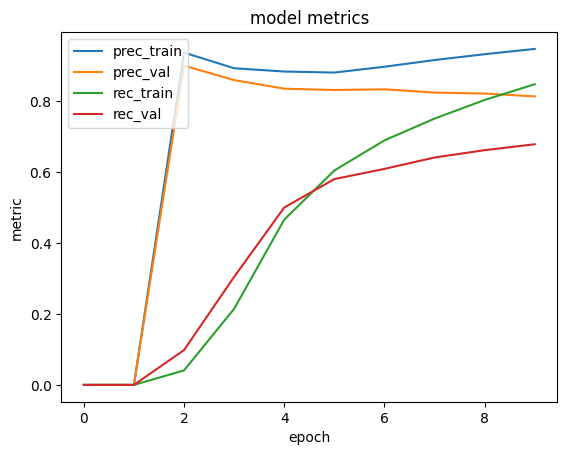

In [42]:
print(model.history.history.keys())
plt.plot(model.history.history['precision'])
plt.plot(model.history.history['val_precision'])
plt.plot(model.history.history['recall'])
plt.plot(model.history.history['val_recall'])
plt.title('model metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['prec_train', 'prec_val', 'rec_train', 'rec_val'], loc='upper left')
plt.show()

А теперь попробуем со сверточным слоем. В керасе они называются Conv1D (2D тоже есть, они используются для картинок). Их нужно ставить сразу после Embedding слоя.

In [54]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

# все остальное точно такое же
# возвращает сверточный слой тоже последовательность векторов слегка измененной или такой же длины
conv1 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(embeddings)

# выход со сверточного слоя также можно просто конкатенировать
concat = keras.layers.Flatten()(conv1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              # еще есть метрика полнота при пороге точности 
              # она очень удобная потому что обычно к модели есть требование минимальной точности
              metrics=[keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall')])


In [55]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 200, 30)        │       722,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 198, 32)        │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6336)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 19)             │       120,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 846,075 (3.23 MB)

 Trainable params: 846,075 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5563 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.1035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8665 - precision: 0.7530 - recall: 0.0343 - val_loss: 1.3392 - val_precision: 0.8221 - val_recall: 0.3021
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1211 - precision: 0.8550 - recall: 0.4437 - val_loss: 0.9785 - val_precision: 0.8156 - val_recall: 0.5744
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7109 - precision: 0.8791 - recall: 0.6696 - val_loss: 0.8409 - val_precision: 0.8239 - val_recall: 0.6519
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4819 - precision: 0.9134 - recall: 0.7828 - val_loss: 0.8235 - val_precision: 0.8183 - val_recall: 0.6885
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3307 - precision: 0.9449 - recall: 0.8595 - val_loss: 0.8501 - val_precision: 0.8067 - val_rec

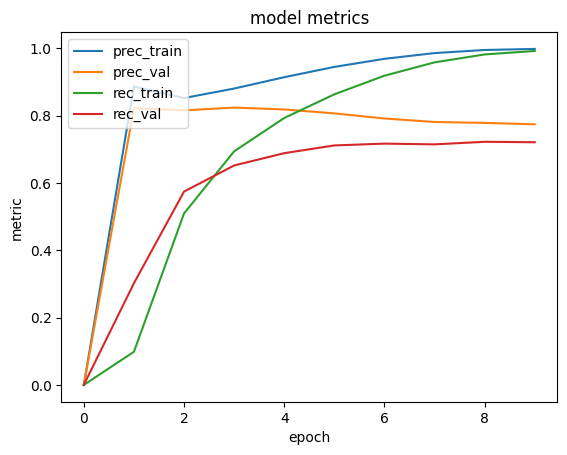

In [57]:
plt.plot(model.history.history['precision'])
plt.plot(model.history.history['val_precision'])
plt.plot(model.history.history['recall'])
plt.plot(model.history.history['val_recall'])
plt.title('model metrics')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['prec_train', 'prec_val', 'rec_train', 'rec_val'], loc='upper left')
plt.show()

Сверточные слои можно накладывать друг на друга.

Давайте еще разберем параметры:  
    **kernel_size** - это размер кусочков, к которым мы применяем сверточные матрицы (похоже на размер нграмма)   
    **filters** - количество матриц свертки  (это как бы размерность до которой будет сжат или развернут вектор)    
    **stride** - шаг по которому выбираются кусочки из последовательности (это как параметр шаг в функции range в питоне)  

In [58]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
conv1 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
concat = keras.layers.Flatten()(conv2)
dense = keras.layers.Dense(64, activation='relu')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [59]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 200, 100)       │     2,409,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 196, 32)        │        16,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 192, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       393,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 19)             │         1,235 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,824,899 (10.78 MB)

 Trainable params: 2,824,899 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.6190 - rec@prec: 0.0000e+00 - val_loss: 2.2574 - val_rec@prec: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1631 - rec@prec: 0.0074 - val_loss: 1.7069 - val_rec@prec: 0.0789
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5282 - rec@prec: 0.2620 - val_loss: 1.3066 - val_rec@prec: 0.4053
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0857 - rec@prec: 0.5779 - val_loss: 1.1354 - val_rec@prec: 0.5500
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7917 - rec@prec: 0.7426 - val_loss: 1.1100 - val_rec@prec: 0.5825
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5803 - rec@prec: 0.8546 - val_loss: 1.1158 - val_rec@prec: 0.6190
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4055 - rec@prec: 0.9230 - val_loss: 1.2399 - val_rec@prec: 0.6032
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2901 - rec@prec: 0.9619 - val_loss: 1.3761

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


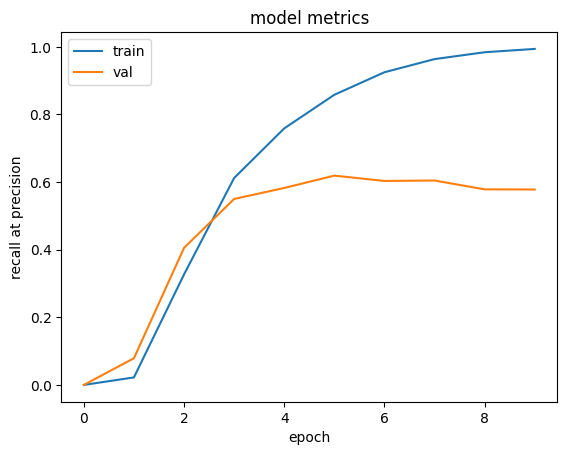

In [61]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Со сверточными слоями часто используется Pooling. Это тоже своего рода свертка, но без обучаемых параметров. В пулингах используется какое-то правило, по которому из чисел в каком-то окне выбирается 1 число (т.е. происходит свертка). В качестве правила используется максимум или среднее. Pooling слой ставят после сверточного. 

In [62]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

conv1 = keras.layers.Conv1D(kernel_size=10, filters=32, strides=5)(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
pool = keras.layers.AveragePooling1D(pool_size=5)(conv2)

concat = keras.layers.Flatten()(pool)
dense = keras.layers.Dense(64, activation='relu')(concat)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [63]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 200, 100)       │     2,409,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 39, 32)         │        32,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 35, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 7, 32)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 19)             │         1,235 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,462,019 (9.39 MB)

 Trainable params: 2,462,019 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# как выглядит ошибка при слишком большом батче
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=15)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1999 - rec@prec: 1.9763e-06 - val_loss: 0.1734 - val_rec@prec: 0.0000e+00
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1717 - rec@prec: 0.0000e+00 - val_loss: 0.1643 - val_rec@prec: 0.0000e+00
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1600 - rec@prec: 0.0016 - val_loss: 0.1420 - val_rec@prec: 0.0582
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1338 - rec@prec: 0.1721 - val_loss: 0.1165 - val_rec@prec: 0.3165
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1030 - rec@prec: 0.4343 - val_loss: 0.1036 - val_rec@prec: 0.4143
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0854 - rec@prec: 0.5865 - val_loss: 0.0982 - val_rec@prec: 0.4811
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0702 - rec@prec: 0.6971 - val_loss: 0.0972 - val_rec@prec: 0.4910
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0565 - rec@prec: 0.7943 - val_loss

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


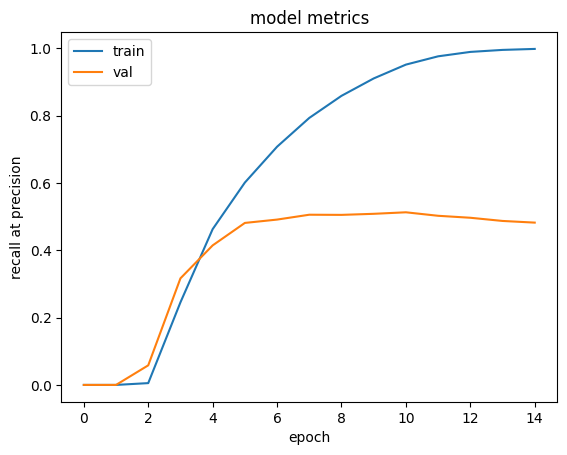

In [66]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Еще один параметр в сверточном слое - padding. Так как мы проходим каким-то окном по последовательности, на выходе последовательность сокращается. Но мы можем добавить нулей в начало и конец, чтобы на выходе было такое же число (padding='same').

Так мы можем наслаивать огромное количество слоев (она не уменьшается на каждом шаге).

А еще это позволяет, например, сделать вот такую сеть:

In [99]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

# мы делаем несколько параллельных сверточных слоев (даже пар слоев с пулингом) с разным окном
# но из-за того, что vы сделали паддинг, длинна получается одинаковая и мы можем сконкатенировать 
# векторы по второй размерности (так же как вы склеивали эбмединги от фастекста и ворд2века в предыдущей домашке)

for ks in [3,4,5,7,10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = keras.layers.concatenate(convs, axis=2)

# а тут мы можем поставить еще свертку
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [101]:
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 200, 100)  │  2,409,200 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 200, 32)   │      9,632 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 200, 32)   │     12,832 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 200, 32)   │     16,032 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 200, 32)   │     22,432 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 200, 32)   │     32,032 │ embedding_19[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 200, 24)   │      2,328 │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 200, 24)   │      3,096 │ conv1d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 200, 24)   │      3,864 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 200, 24)   │      5,400 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 200, 24)   │      7,704 │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 120)  │          0 │ conv1d_27[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_29[0][0],  │
│                     │                   │            │ conv1d_31[0][0],  │
│                     │                   │            │ conv1d_33[0][0],  │
│                     │                   │            │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 196, 32)   │     19,232 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 6272)      │          0 │ conv1d_36[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 50)        │    313,650 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 19)        │        969 │ dense_32[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,858,403 (10.90 MB)

 Trainable params: 2,858,403 (10.90 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20)

Epoch 1/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 1.5694 - rec@prec: 0.0000e+00

/home/ubuntu/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/backend/torch/nn.py:466: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  outputs = tnn.conv1d(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.4012 - rec@prec: 0.0000e+00 - val_loss: 0.9885 - val_rec@prec: 0.0050
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.8865 - rec@prec: 5.3045e-04 - val_loss: 0.6197 - val_rec@prec: 0.0275
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.5515 - rec@prec: 0.1149 - val_loss: 0.3897 - val_rec@prec: 0.2849
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.3418 - rec@prec: 0.4645 - val_loss: 0.2602 - val_rec@prec: 0.4666
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.2181 - rec@prec: 0.6586 - val_loss: 0.1896 - val_rec@prec: 0.5289
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1452 - rec@prec: 0.7561 - val_loss: 0.1604 - val_rec@prec: 0.4869
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0998 - rec@prec: 0.8245 - val_loss: 0.1275 - val_rec@prec: 0.5775
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0678 - rec@prec: 0.8965 - val_loss: 0.1242 - val_rec@

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


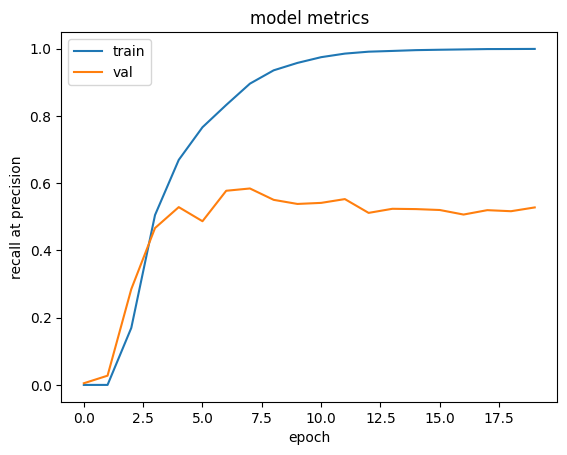

In [103]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Можно отдельно посмотреть, что делает паддинг в случае тензоров. Есть отдельный слой, который позволяет контролировать, куда и сколько паддить.

In [104]:
# создадим тензор для примера
# обратите внимание на размерности 
# (batch_size, max_len, embedding_size)
# в нашем случае это можно прочитать как 
# два текста, каждый длинной 3 и размерностью каждого слова 4
input_shape = (2, 3, 4)
x = np.arange(np.prod(input_shape)).reshape(input_shape)
x

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

Теперь используем `ZeroPadding1D` чтобы добавить по два эмбеддинга с каждой стороны в каждый текст.

In [105]:
y = keras.layers.ZeroPadding1D(padding=1, )(x)

In [106]:
# изменилась только размерность max_len (теперь каждый текст это пять эмбеддингов)
y.shape

torch.Size([2, 5, 4])

In [107]:
# мы добавили по два нулевых эмбединга до и после изначальных эмбеддингов
y

tensor([[[ 0,  0,  0,  0],
         [ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [ 0,  0,  0,  0]],

        [[ 0,  0,  0,  0],
         [12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23],
         [ 0,  0,  0,  0]]], device='cuda:0')

In [108]:
# через tuple может указать сколько добавить с каждой из сторон
y = keras.layers.ZeroPadding1D(padding=(1,2))(x)

In [109]:
# также увеличилась только средняя размерность
y.shape

torch.Size([2, 6, 4])

In [110]:
# один нулевой эмбединг слева (до) и два справа (после)
y

tensor([[[ 0,  0,  0,  0],
         [ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        [[ 0,  0,  0,  0],
         [12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]]], device='cuda:0')

## Сохранение и загрузка модели

Когда какая-то модель получилась, её может потребоваться сохранить.

In [112]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                activation='relu')(conv1)
    convs.append(conv2)
concat = keras.layers.concatenate(convs, axis=2)
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [113]:
model.save('model.keras')

In [114]:
model = keras.models.load_model('model.keras')

/home/ubuntu/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Можно сохранить только веса, но потом придется задать модель и только после этого загрузить веса.

In [115]:
model.save_weights('model.weights.h5')

In [116]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
concat = keras.layers.concatenate(convs, axis=2)
conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [117]:
model.load_weights('model.weights.h5')

/home/ubuntu/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 48 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Callbacks

Еще есть такая штука как колбеки. С помощью них можно сохранять модель с лучшим результатом, останавливать обучение, если уже не обучается или менять learning_rate в зависимости от текущего состояния. С колбеками можно поставить нейронку обучаться и заняться какими-то другими делами, зная, что лучшие веса сохранятся.

Описание стандартных колбеков - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [126]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла 
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [130]:
inputs = keras.layers.Input(shape=(MAX_LEN,))

embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = keras.layers.Dropout(0.3)(embeddings)
conv1 = keras.layers.Conv1D(kernel_size=3, filters=128, strides=1, 
                            activation='relu')(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=128, strides=2, 
                            activation='relu')(conv1)

drop2 = keras.layers.Dropout(0.5)(conv2) # это значит что случайно заменяется половина всех значений

flatten = keras.layers.Flatten()(drop2)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')],
              )


In [131]:

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=100,
         callbacks=[checkpoint, early_stop])

Epoch 1/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1887 - rec@prec: 7.7888e-06
Epoch 1: val_rec@prec did not improve from 0.58115
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1878 - rec@prec: 9.1751e-06 - val_loss: 0.1680 - val_rec@prec: 0.0018
Epoch 2/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1662 - rec@prec: 3.7380e-04
Epoch 2: val_rec@prec did not improve from 0.58115
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1658 - rec@prec: 3.6812e-04 - val_loss: 0.1524 - val_rec@prec: 0.0000e+00
Epoch 3/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1478 - rec@prec: 0.0126
Epoch 3: val_rec@prec did not improve from 0.58115
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1475 - rec@prec: 0.0148 - val_loss: 0.1302 - val_rec@prec: 0.1393
Epoch 4/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1188 - rec@prec: 0.2806
Epoch 4: val_rec@prec did not improve from 0.58115
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1184 - rec@prec: 0.2870 - val_loss

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


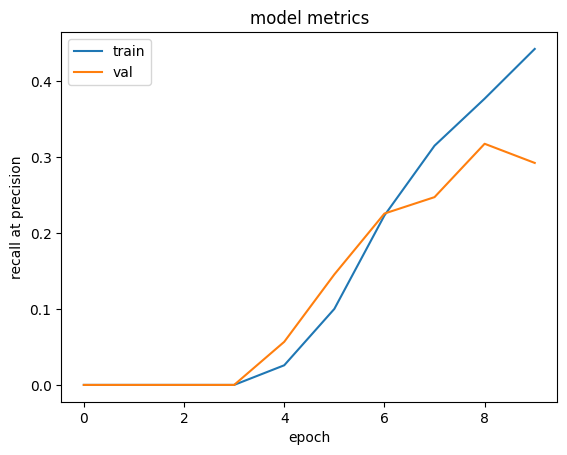

In [124]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [132]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   214M      0  0:00:03  0:00:03 --:--:--  214M


In [133]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   model.weights.h5
 PetImages		   lenta_40k.csv.zip	       'readme[1].txt'
 cnn_keras.ipynb	   model.keras


In [134]:
!ls PetImages

Cat  Dog


In [135]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [9]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import random

In [5]:
data_transform = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [10]:
data = datasets.ImageFolder(
    root="PetImages",
    transform=data_transform,
    
)

In [11]:
len(data)

23410

In [12]:
training_data, validation_data = torch.utils.data.random_split(data, lengths=[len(data)-100, 100])

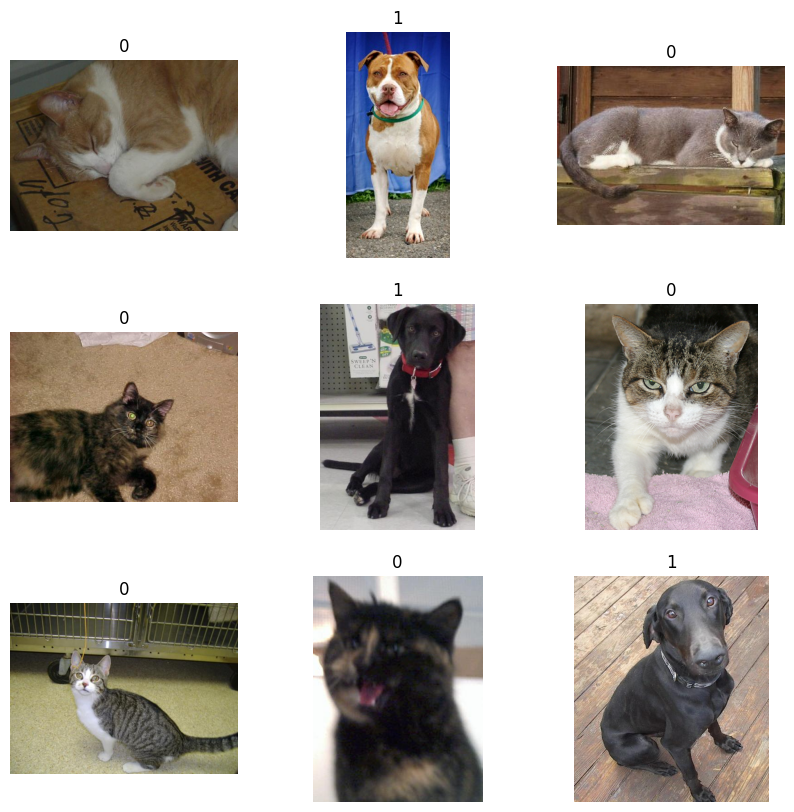

In [13]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(random.choices(validation_data.dataset.samples, k=9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(Image.open(image)))
    plt.title(int(label))
    plt.axis("off")

In [14]:
batch_size = 32

trainLoader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, 
                                           drop_last=True, shuffle=True)
valLoader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
  

In [15]:
inputs = keras.Input(shape=(3, 224, 224), )

x = keras.layers.Conv2D(128, 3, strides=2, padding="same", data_format='channels_first')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.SeparableConv2D(1024, 3, data_format='channels_first', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalAveragePooling2D(data_format='channels_first')(x)


x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation=None)(x)
model = keras.Model(inputs, outputs)

In [16]:
epochs = 3

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 224, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 112, 112)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 112, 112)  │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 112, 112)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1024, 112, 112) │       133,248 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024, 112, 112) │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024, 112, 112) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,753 (542.00 KB)

 Trainable params: 138,305 (540.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.fit(
    trainLoader,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=valLoader,
)

Epoch 1/3
161/728 ━━━━━━━━━━━━━━━━━━━━ 2:46 294ms/step - acc: 0.5156 - loss: 0.7045

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
This image is 53.14% cat and 46.86% dog.


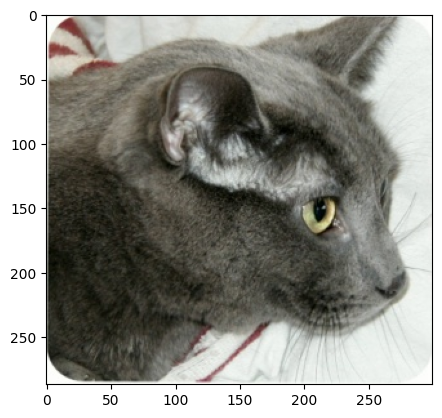

In [248]:
img = Image.open("PetImages/Cat/6779.jpg")
plt.imshow(img)
predictions = model.predict(data_transform(img).unsqueeze(0))
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
